In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from analysis import load_configs, load_experimental_results, get_stats
from factorization.config import IMAGE_DIR
from factorization.models.mlp import Model


def get_names(name):
    match name:
        case "iid":
            return "iid", ["input_factors", "output_factors", "alphas", "batch_size"]
        case "compression":
            return "compression", ["input_factors", "output_factors", "emb_dim", "nb_layers"]
        case "factor":
            return "exp1_factor", ["input_factors", "output_factors"]
        case "dim":
            return "exp1_dim", ["emb_dim"]
        case "layer":
            return "exp1_layer", ["nb_layers"]
        case "lr":
            return "exp1_lr", ["learning_rate"]
        case "split":
            return "exp1_split", ["data_split"]
        case "ffn":
            return "exp1_ffn", ["ffn_dim"]
        case "bernouilli":
            return "filtration", ["bernouilli"]


In [3]:
kwargs = {
    # "bernouilli_seed": 0,
    "alphas": 1e-3,
    "batch_size": 32,
    "final": False, # wether to load last epoch only
}

name = "iid"
xaxis = "epoch"

file_path, study_factors = get_names(name)

all_configs = load_configs(file_path)
res = load_experimental_results(all_configs, **kwargs)

res['flops'] = Model.get_flops(res['emb_dim'], res['ffn_dim'], res['nb_layers'], res['output_size'])
res['flops'] *= res['epoch'] * res['data_split']

In [10]:
all_mean, all_std, keys = get_stats(res, study_factors, xaxis=xaxis, **kwargs)

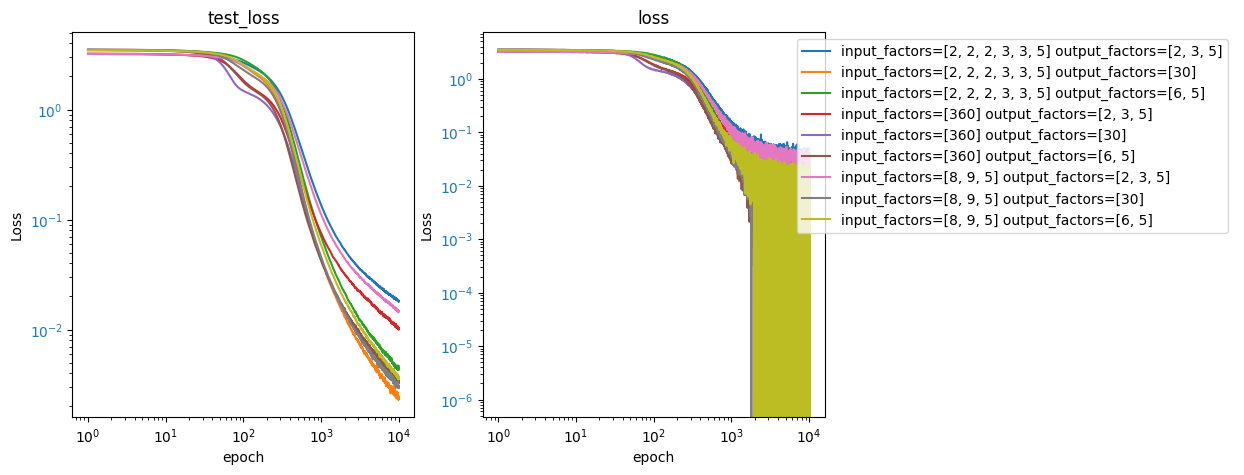

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, name in zip(axes, ['test_loss', 'loss']):
    color = 'C0'
    legend = []
    all_plots = []
    for val, val_std in zip(all_mean, all_std):
        a, = ax.plot(val[name])
        all_plots.append(a)
        # ax.fill_between(val.index, val[name] - val_std[name], val[name] + val_std[name], alpha=0.5)
        leg = ' '.join([f'{key}={val[key].values[0]}' for key in keys])
        legend.append(leg)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(xaxis)
    ax.set_ylabel('Loss')
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_title(name)
    # ax.set_ylim(4.5, 4.75)

ax = axes[2]
ax.axis('off')
ax.legend(all_plots, legend)

ax.grid()
fig.savefig(IMAGE_DIR / f'{name}.pdf')